### Calculating solvation free energies (example with PySCF)

**Author**: Timo Weckman
**Date**: 2025-05

The dielectric continuum solvent models facilitate the modelling of chemical reactions is condensed phases. The dielectric continuum models the effect of the solvent and can be used to compute the solvation free energy of a species. The solvation free energy $\Delta G_\text{solv}$ can be added to the accurate gas-phase free energy values to obtain the corresponding solution-phase free energy: 

$$G_\text{soln} = G_\text{gas} + \Delta G_\text{solv} + RT \ln \left( \frac{RT}{P} \right)$$

where the last term converts the gas-phase standard state to teh solution-phase standard state of 1 M. 

However, there are a few points one needs to address when the continuum solvent models are applied (see https://doi.org/10.1021/jp107136j). The solvation free energy can be computed from the difference between the energies obtained in gas-phase and in the dielectric continuum solvent, 

$$\Delta G_\text{solv} = (E_\text{soln} + G_\text{nes}) - E_\text{gas}$$

where $E_\text{soln}$ and $ E_\text{gas}$ are the electronic energies of the solute with and without the continuum solvent field and $G_\text{nes}$ refers to the sum of any nonelectrostatic contributions to the solvation free energy, such as cavitation and dispersion-repulsion interactions. 
The main point here is that the **solvation free energy** is obtained from the difference in **electronic energies**, **not** a difference in free energies computed in solution- and gas-phases. *This is because of the way the continuum models are parametrized and from the fact that the ideal gas models used to compute the free energies only apply in the gas-phase.*

So, in order to calculate all the components of our thermodynamic cycle we will:
1. Optimize all the species in the upper-rung of the thermodynamic cycle in gas-phase
2. Compute the total energy and all the free energy terms for these species
3. Optimize all the species in the lower-rung of the thermodynamic cycle with the dielectric continuum solvent model

We will then compute the free energy for the reaction based on the gas-phase free energies,

$$\Delta G_\text{bind, g} = \sum_i \nu_i G_\text{i} - \sum_a \nu_a G_a$$

where $i$ and $a$ correspond to product and reactant species, respectively.

The solvation energies are then computed using the electronic energies of the species (not including the enthalpy and entropy-terms used in gas-phase calculation). 

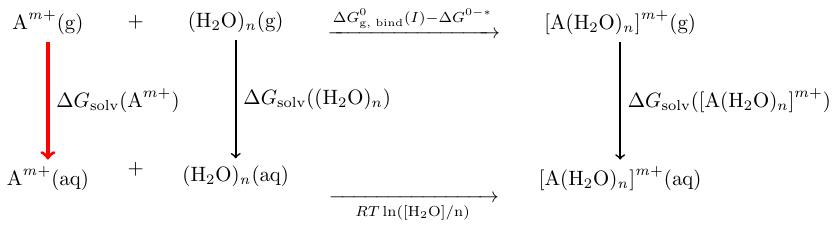

In [3]:
from IPython.display import display, Image
display(Image(filename='scheme1.png'))

### Hybrid solvation model

Often, especially for ionic systems, it is preferred to employ a hybrid solvation model, that is to use both explicit and implicit solvent together. This will signicantly improve the accuracy of our solvation energies.

Let's proceed step-by-step using the PySCF and calculate the solvation energy of copper(II)-ion.

### Implicit solvent only

We'll define a simple system consisting of the copper-ion in gas-phase and with implicit solvent only.

In [79]:
from pyscf import gto, scf, solvent

mol = gto.Mole()
mol.atom = 'Cu 0 0 0' 
mol.basis = 'def2-svp' 
mol.charge = 2 
mol.spin = 1
mol.build()

mf = scf.UKS(mol)
mf.xc = 'PBE'
mf.verbose = 0
mf.run()

# Add implicit solvent
mf_solvent = solvent.ddCOSMO(mf)
mf_solvent.with_solvent.eps = 78.39
mf_solvent.verbose = 0
mf_solvent.mo_coeff = mf.mo_coeff
mf_solvent.run()

print(f"Total energy in vacuum: {mf.e_tot: .3f} Eh")
print(f"Total energy in solvent: {mf_solvent.e_tot: .3f} Eh")
print(f"Solvation free energy: {(mf_solvent.e_tot - mf.e_tot) * 627.5: .3f} kcal/mol")

Total energy in vacuum: -1638.931 Eh
Total energy in solvent: -1639.475 Eh
Solvation free energy: -341.570 kcal/mol


The evaluated solvation energy is quite off the mark, considering that the solvation free is estimated to be about -500 kcal/mol (see https://pubs.acs.org/doi/abs/10.1021/acs.jpca.8b06674). 

### Hybrid solvation model

Let's embed the copper-ion in a solvation shell formed by water molecules and compute the solvation free energy using the thermodynamic cycle discussed above. This is considerably more involved calculation, since we need to compute the Hessian for the gas-phase species. 

How do we obtain a structure for the solvation shell? This is a good question. Some might be found from the literature, at least for a similar ion. An alternative approach would be to construct one using a low-level model, e.g. density functional tight binding (DFTB) or similar approach. Here, we will adopt an artificially small cluster with four water molecules. There are however larger solvation structures available from the literature (see e.g. https://pubs.acs.org/doi/10.1021/jp804373p).

### Water cluster structures

Consider the two water clusters, with and without a copper-ion, preoptimized using PBE and def2-SVP basis set.

We will use these clusters to calculate the gas-phase reaction for the binding of the copper-ion with the solvent molecules. We will also use them to calculate the solvation energy for each cluster. The solvated structure should be optimized, but we will neglect this step here since the calculations, albeit with a small basis set, are already quite cumbersome to run on a laptop/desktop. 

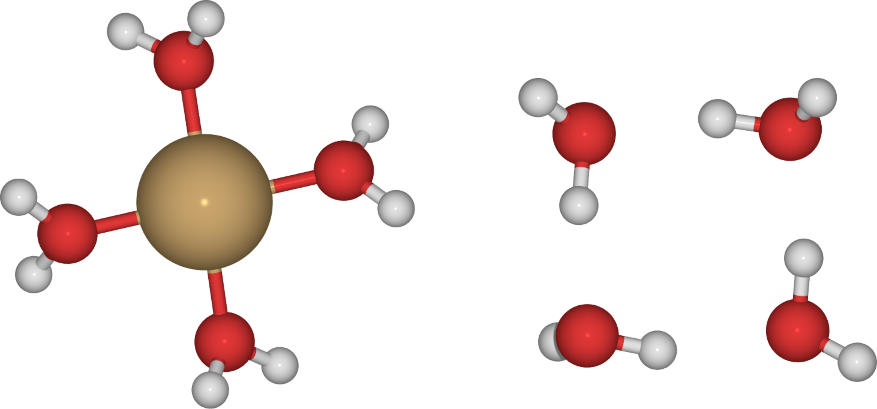

In [8]:
display(Image(filename='solvationcluster.png'))

In [80]:
from pyscf.hessian import thermo

# First, compute copper with the 'solvation cluster'
coords = '''
  Cu  0.00770670007957     -0.01075714803486      0.00684346198661
  O   1.62629858055350      0.59958796551543     -0.96137824606612
  H   2.38274772811028      0.05517739425091     -1.27095980213712
  H   1.63486316135084      1.44991263891621     -1.45427267152436
  O   -0.08513692098164      1.85563301721865      0.70772230089222
  H   -0.92091296008101      2.27895856953297      1.00777628197219
  H   0.63973505010478      2.22714364462856      1.26089012590088
  O   -0.16307318602147     -1.71475219698127     -1.01669913168950
  H   0.12868744546777     -1.79759035478399     -1.95233645651861
  H   -0.00508273379089     -2.58677644056665     -0.58749562922375
  O   -1.47600452153588     -0.67910102216609      1.13003992630434
  H   -1.68821978806555     -0.41530609819069      2.05174002936686
  H   -2.28219008519028     -1.07343020933916      0.72891087073636
'''

temperature = 298.15  # Standard temperature in K
pressure = 101325  # Standard pressure in Pa

mol_cluster = gto.M(atom=coords, basis='def2-svp', charge=2, spin=1)
mf_cluster = scf.UKS(mol_cluster)
mf_cluster.xc = 'PBE'
mf_cluster.verbose = 0
mf_cluster.run()

hessian = mf_cluster.Hessian().kernel()
# Frequency analysis
freq_cluster = thermo.harmonic_analysis(mf_cluster.mol, hessian)
thermo_cluster = thermo.thermo(mf_cluster, freq_cluster['freq_au'], temperature, pressure)

In [81]:
# Second, compute just the 'solvation cluster'
coords = '''
  O   1.59569157211650      0.52671408407826      0.55875125592345
  H   1.22572269113165      0.40613430342645     -0.37753454653395
  H   1.65562959781890     -0.39080578496591      0.88476545887585
  O   -1.80219894908837      1.36621874756072     -0.76471975545405
  H   -1.46831586426498      1.39336098953180      0.19232417112175
  H   -1.87403013018684      2.30887164269416     -1.00164540312905
  O   0.36899920133373      0.20801276276540     -1.77155683816915
  H   0.69644080847323      0.81096729919872     -2.46358962449703
  O   -0.64414560352736      1.46201234097889      1.62413639246884
  H   -0.47158383660499      2.36988722572480      1.93233540537252
  H   0.25833209306559      1.14749559670315      1.28200372985479
  H   -0.51999897026706      0.60946637230353     -1.49946089583396
'''

mol_solvent = gto.M(atom=coords, basis='def2-svp', charge=0, spin=0)
mf_solvent = scf.UKS(mol_solvent)
mf_solvent.xc = 'PBE'
mf_solvent.verbose = 0
mf_solvent.run()

hessian = mf_solvent.Hessian().kernel()
# Frequency analysis
freq_solvent = thermo.harmonic_analysis(mf_solvent.mol, hessian)
thermo_solvent = thermo.thermo(mf_solvent, freq_solvent['freq_au'], temperature, pressure)

In [82]:
# Third, compute just the copper ion separately
coords = '''
  Cu   0.0      0.0      0.0
'''

mol_cu = gto.M(atom=coords, basis='def2-svp', charge=2, spin=1)
mf_cu = scf.UKS(mol_cu)
mf_cu.xc = 'PBE'
mf_cu.verbose = 0
mf_cu.run()

For the gas-phase copper-ion, we need to compute the translational entropy using the Sackur-Tetrode equation, 

$$S_\text{trans} = R \left( \ln \left( \frac{kT}{P} \left( \frac{2\pi mkT}{h^2} \right)^{\frac{3}{2}} \right) + \frac{5}{2} \right)
$$

In [83]:
from pyscf.data import nist
import numpy as np

# Conversion factors from PySCF's NIST database
kB = nist.BOLTZMANN
h = nist.PLANCK
# Gas constant in units of Hartree
R_Eh = kB*nist.AVOGADRO / (nist.HARTREE2J * nist.AVOGADRO)
# Mass of the atom
mass_tot = np.sum(mol_cu.atom_mass_list()) * nist.ATOMIC_MASS
# Sackur-Tetrode equation for the translational entropy
S_trans = R_Eh * (np.log((2.0 * np.pi * mass * kB * temperature / h**2)**1.5 * kB * temperature / pressure) + 5/2)
thermo_cu = mf_cu.e_tot - temperature * S_trans

In [84]:
dGbind_gas = (thermo_cluster['G_tot'][0] - thermo_solvent['G_tot'][0] - thermo_cu) * 627.5
print(f"Gibbs free energy for the gas-phase reaction: {dGbind_gas: .3f} kcal/mol")

Gibbs free energy for the gas-phase reaction: -299.312 kcal/mol


The solvation energies are computed from the electronic energies between the gas-phase and solvated molecules.

In [71]:
# Add implicit solvent to cluster and solvent
mf_cluster_solvation = solvent.ddCOSMO(mf_cluster)
mf_cluster_solvation.with_solvent.eps = 78.39
mf_cluster_solvation.verbose = 0
mf_cluster_solvation.mo_coeff = mf_cluster.mo_coeff
mf_cluster_solvation.run()

mf_solvent_solvation = solvent.ddCOSMO(mf_solvent)
mf_solvent_solvation.with_solvent.eps = 78.39
mf_solvent_solvation.verbose = 0
mf_solvent_solvation.mo_coeff = mf_solvent.mo_coeff
mf_solvent_solvation.run()

dGsolv_cluster = (mf_cluster_solvation.e_tot - mf_cluster.e_tot) * 627.5
dGsolv_solvent = (mf_solvent_solvation.e_tot - mf_solvent.e_tot) * 627.5
print(f"Solvations free energies for the cluster: {dGsolv_cluster: .3f} kcal/mol")
print(f"Solvations free energies for the solvent: {dGsolv_solvent: .3f} kcal/mol")

Solvations free energies for the cluster: -202.658 kcal/mol
Solvations free energies for the solvent: -8.953 kcal/mol


We also need to account for the change in the standard state when going from gas-phase to the solution phase:


In [85]:
print(f"Solvation free energy of copper(II) in water: {dGbind_gas + dGsolv_cluster - dGsolv_solvent: .3f} kcal/mol")

Solvation free energy of copper(II) in water: -493.016 kcal/mol


This gets very close to the experimental value, although we have performed only very simple calculations with DFT+GGA, no van der Waals correction and only a small basis set. Using more accurate setup and a larger solvation cluster should improve on this. The convergence of the results with respect to the basis set used and the size of the solvation cluster should be checked.